## Import packages and set seed

- It is highly probable that the folder "auxiliary_scripts" will change its name in the future.
- If this happens then it would be converted into a package called "wavesuite_auxiliary_scripts" and it would have to be installed and imported

In [1]:
import sys

sys.path.insert(0, '../../auxiliary_scripts/')

# test_number = 1    #1 or 2

In [2]:
import numpy as np
import vtktools
import matplotlib.pyplot as plt 

import time  

import torch
import torch.nn as nn 

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [3]:
from test_just_model2AE import model2_variant1 ,  model2_variant2 ,  model2_variant3
from test_just_model2AE import model2_variant4, model2_variant5 ,  model2_variant6

In [4]:
from train_AE_functions import set_seed , train_AE_epoch, validate_AE_epoch , model_MSE_error

from graph_functions import get_node_features, get_complete_edge_list, create_graph_data_list_vtu_file
from plot_results_vtu import plot_model_2d_vtu, compare_three_plots_models_2d_vtu 

from rank_models import plot_losses , rank_losses

In [5]:
from livelossplot import PlotLosses 

set_seed(42)

True

## Create the list of Data objects where each element is a graph

In [6]:
location = '../../../Datasets/air_pollution_data/2d_canyon_' 
start_index = 0
end_index = 401

vtu_file_locations_air = [ location + str(i) + '.vtu' for i in range(start_index, end_index)]
features_list_air = ['TracerBackground']  # ['TracerBackground','Velocity']

In [7]:
graph_data_list_air, n_points = create_graph_data_list_vtu_file(vtu_file_locations_air, features_list_air)

In [8]:
graph_data_list_air[0]

Data(x=[852, 1], edge_index=[2, 2419])

## Shuffle graph_data_list before splitting

In [9]:
#Compute the number of graphs
n_graphs = len(graph_data_list_air)

#Compute one random permutation
permutation0 = np.random.permutation(n_graphs)

In [10]:
shuffle = True

if shuffle:
    #Reorganize graph_data_list taking into account the previous random permutation
    input_graph_data_list = [graph_data_list_air[entry] for entry in permutation0]
else: 
    input_graph_data_list = graph_data_list_air

## Create DataLoaders

In [11]:
n_graphs = len(input_graph_data_list)

graph_data_list_train = input_graph_data_list[:int(n_graphs * 0.8)]
graph_data_list_validation = input_graph_data_list[int(n_graphs * 0.8):int(n_graphs * 0.9)]
graph_data_list_test = input_graph_data_list[int(n_graphs * 0.9):]

print(len(graph_data_list_train))
print(len(graph_data_list_validation))
print(len(graph_data_list_test))

320
40
41


In [12]:
NUM_GRAPHS_PER_BATCH = 32

train_loader = DataLoader(graph_data_list_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(graph_data_list_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data_list_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Copy train_AE frunction but modify the available model2_variants

In [13]:
def train_AE(train_loader, validation_loader, 
             num_nodes, num_features, embedding_sequence, latent_space_dim,
             ae_model_type='classic_AE', num_epochs=50, plot_losses=True, 
             seed=42, device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ,
             use_sgd_instead_of_adam=False, lr=1e-1, momentum=0.2):
    
    set_seed(seed)
    
    invalid_entry = False
    
    if ae_model_type=='model2_variant1':
        model = model2_variant1(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model2_variant2':
        model = model2_variant2(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model2_variant3':
        model = model2_variant3(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model2_variant4':
        model = model2_variant4(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model2_variant5':
        model = model2_variant5(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    elif ae_model_type=='model2_variant6':
        model = model2_variant6(num_nodes, num_features, embedding_sequence, latent_space_dim).to(device)
    else:
        invalid_entry = True
        print('\n An invalid ae_model_type was provided, a classic AE was used as default')
        # model = classic_AE(num_nodes, num_features, latent_space_dim).to(device)
    
    ## The ADAM is the default, since the ADAM optimizer performs better in this case compared against SGD  
    optimizer = torch.optim.Adam(model.parameters())
    if use_sgd_instead_of_adam:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    ## The loss here is the mean_squared_error because the model is an AE
    criterion = nn.MSELoss()
    
    if plot_losses:
        liveloss = PlotLosses()
    loss_register = []
    
    for epoch in range(num_epochs):
        #During each epoch update the parameters
        train_temp_loss = train_AE_epoch(model, optimizer, criterion, train_loader, device, num_nodes)
        
        #Optional: Check the validation loss in each epoch
        validation_temp_loss = validate_AE_epoch(model, criterion, validation_loader, device, num_nodes) 
        
        #Compute the losses in each iteration 
        logs = {}
        logs['' + 'log loss'] = train_temp_loss.item()
        logs['val_' + 'log loss'] = validation_temp_loss.item()
        loss_register.append(logs)
        
        #Optionally plot the train and validation loss   
        if plot_losses:
            liveloss.update(logs)
            liveloss.draw()
            
    if invalid_entry == True:
        print('\n An invalid ae_model_type was provided, a classic AE was used as default') 
        
    print("\n Number of parameters: ", sum(p.numel() for p in model.parameters()))
    
    #At the end just return 1. the model with the trained parameters and 2. the list of losses in every epoch
    return model, loss_register 


## Let's train some models

In [14]:
#This dictionary stores the losses results of the models
results_variants = {}

In [15]:
#These are the models specifications
num_features = 1  #This is always 1
embedding_sequence = [8, 16, 2]  #The third entry determines the number of parameters
latent_space_dim = 32
num_epochs = 50  

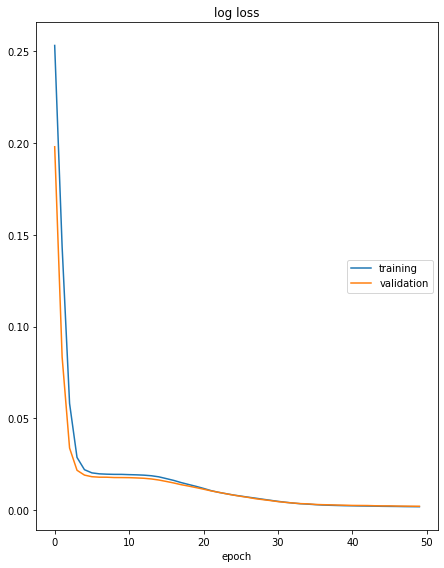

log loss
	training         	 (min:    0.002, max:    0.253, cur:    0.002)
	validation       	 (min:    0.002, max:    0.198, cur:    0.002)

 Number of parameters:  168886
Time taken:  22.20464253425598


In [16]:
start = time.time()

var_name = 'test'+'_variant1'

variant1, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant1', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

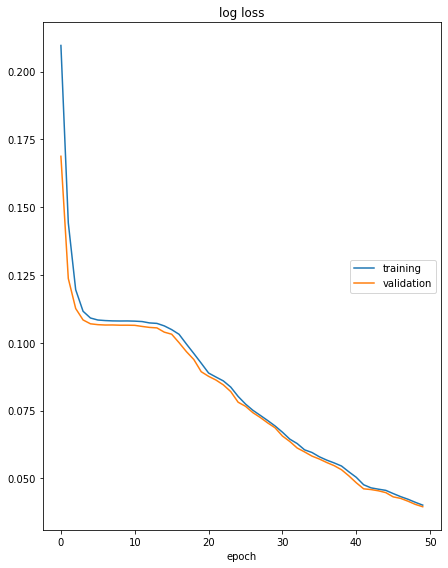

log loss
	training         	 (min:    0.040, max:    0.210, cur:    0.040)
	validation       	 (min:    0.040, max:    0.169, cur:    0.040)

 Number of parameters:  168886
Time taken:  13.401256561279297


In [17]:
start = time.time()

var_name = 'test'+'_variant2'

variant2, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant2', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

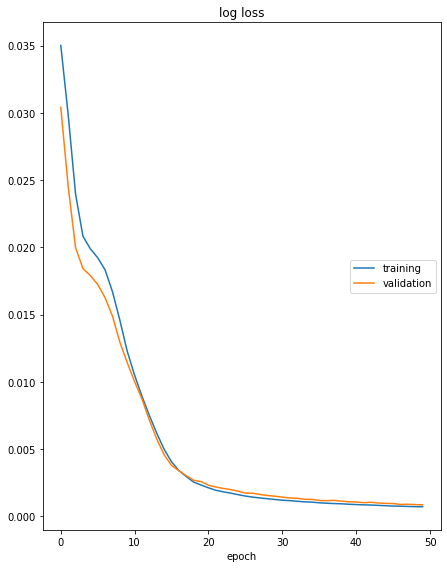

log loss
	training         	 (min:    0.001, max:    0.035, cur:    0.001)
	validation       	 (min:    0.001, max:    0.030, cur:    0.001)

 Number of parameters:  168886
Time taken:  13.970250368118286


In [18]:
start = time.time()

var_name = 'test'+'_variant3'

variant3, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant3', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

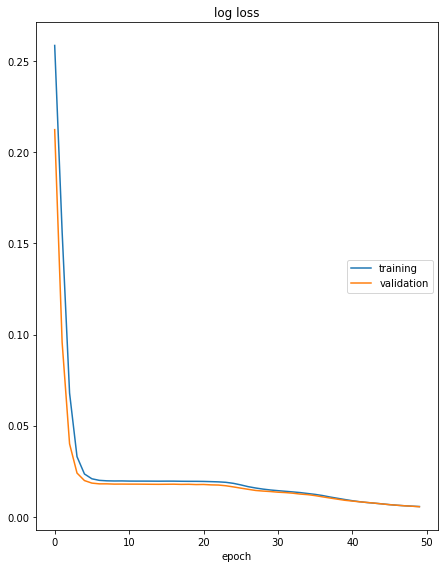

log loss
	training         	 (min:    0.006, max:    0.259, cur:    0.006)
	validation       	 (min:    0.006, max:    0.212, cur:    0.006)

 Number of parameters:  168886
Time taken:  13.339224576950073


In [19]:
start = time.time()

var_name = 'test'+'_variant4'

variant4, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant4', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

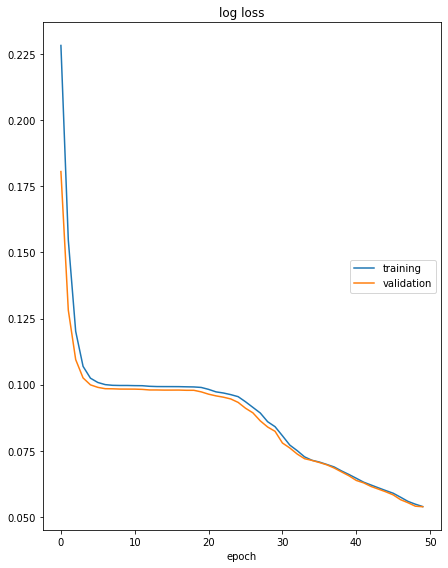

log loss
	training         	 (min:    0.054, max:    0.228, cur:    0.054)
	validation       	 (min:    0.054, max:    0.181, cur:    0.054)

 Number of parameters:  168886
Time taken:  13.72647500038147


In [20]:
start = time.time()

var_name = 'test'+'_variant5'

variant5, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant5', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

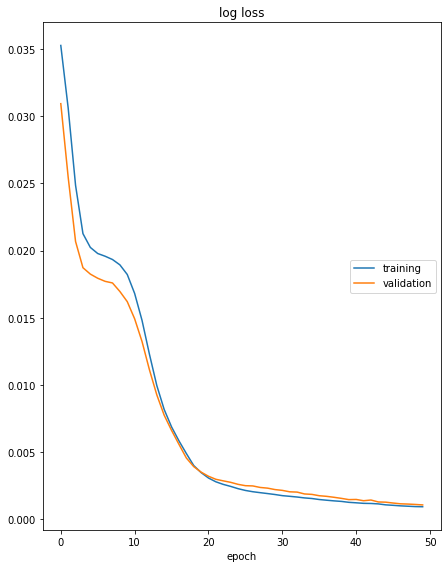

log loss
	training         	 (min:    0.001, max:    0.035, cur:    0.001)
	validation       	 (min:    0.001, max:    0.031, cur:    0.001)

 Number of parameters:  168886
Time taken:  13.7627854347229


In [21]:
start = time.time()

var_name = 'test'+'_variant6'

variant6, results_variants[var_name] = train_AE(train_loader, validation_loader, 
                                                    n_points, num_features, embedding_sequence, latent_space_dim, 
                                                    ae_model_type='model2_variant6', num_epochs=num_epochs )

end = time.time()

print('Time taken: ',end-start)

## MSE results

In [22]:
variants_names = list( results_variants.keys() )

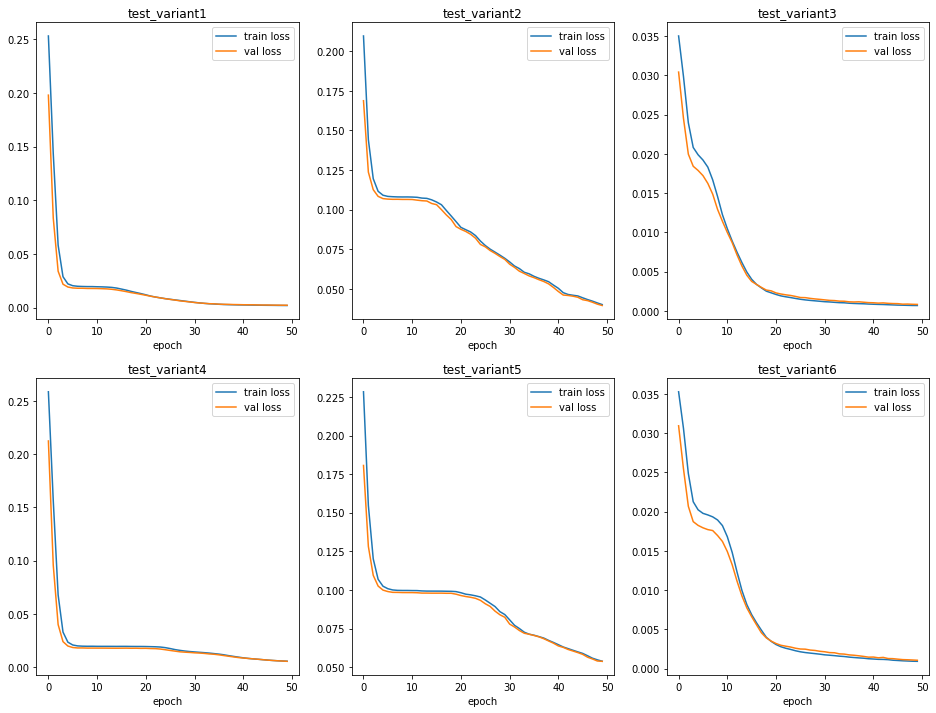

In [23]:
filename = 'model2_air_pollution_test'+'_variants_losses.png'
plot_losses(results_variants, variants_names, filename=filename, figsize=(16,12))

In [24]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,test_variant3,0.008705
1,test_variant6,0.013234
2,test_variant1,0.017574
3,test_variant4,0.017954
4,test_variant5,0.098207
5,test_variant2,0.106025


In [25]:
rank_losses(results_variants, variants_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,test_variant3,0.001860
1,test_variant6,0.002602
2,test_variant1,0.008230
3,test_variant4,0.016443
4,test_variant2,0.078076
5,test_variant5,0.093280


In [26]:
first_column_model_name = 'Model2'
filename = 'model2_air_pollution_test'+'_variants_losses.csv'

df_losses = rank_losses(results_variants, variants_names, selected_epoch = num_epochs,
                       first_column_model_name = first_column_model_name, filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,Model2,test_variant3,0.000843
1,Model2,test_variant6,0.001070
2,Model2,test_variant1,0.002146
3,Model2,test_variant4,0.005562
4,Model2,test_variant2,0.039531
5,Model2,test_variant5,0.053800


In [27]:
print( 'model2_variant1 error: ', model_MSE_error(variant1, train_loader) )
print( 'model2_variant2 error: ', model_MSE_error(variant2, train_loader) )
print( 'model2_variant3 error: ', model_MSE_error(variant3, train_loader) )
print( 'model2_variant4 error: ', model_MSE_error(variant4, train_loader) )
print( 'model2_variant5 error: ', model_MSE_error(variant5, train_loader) )
print( 'model2_variant6 error: ', model_MSE_error(variant6, train_loader) )

model2_variant1 error:  0.0018666822
model2_variant2 error:  0.039682467
model2_variant3 error:  0.0006782699
model2_variant4 error:  0.0054677906
model2_variant5 error:  0.053617574
model2_variant6 error:  0.0008940302


# Plot the results

In [28]:
filename_to_copy_structure = '../../../Datasets/air_pollution_data/2d_canyon_0.vtu'

Indexes plotted [1, 10, 20, 39]


C:\Users\angel\Anaconda3\envs\second-try-alienware\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


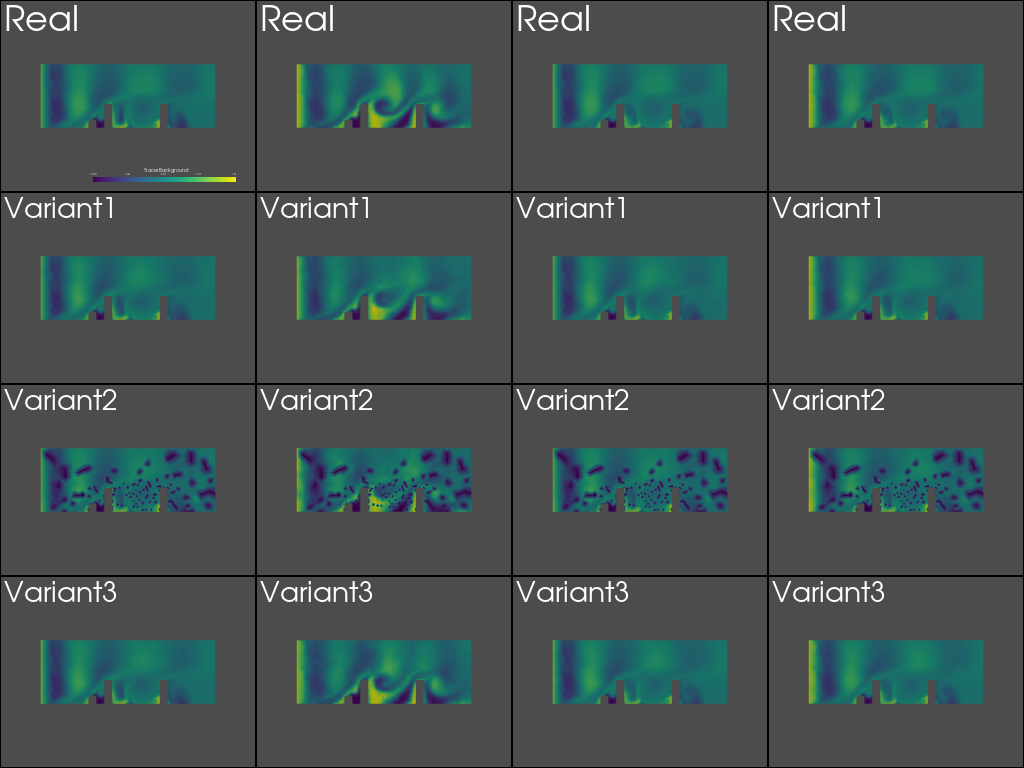

In [29]:
compare_three_plots_models_2d_vtu(variant1, variant2, variant3,
                            graph_data_list_test, 4 , filename_to_copy_structure, 
                            random=False, index_sequence=[ 1, 10, 20, 39],
                                set_pred_labels_as = ["Variant1", "Variant2", "Variant3"],
                                 save_fig=True, filename='air_pollution_model2_variants_1to3.eps' )

Indexes plotted [38 28 14  7]


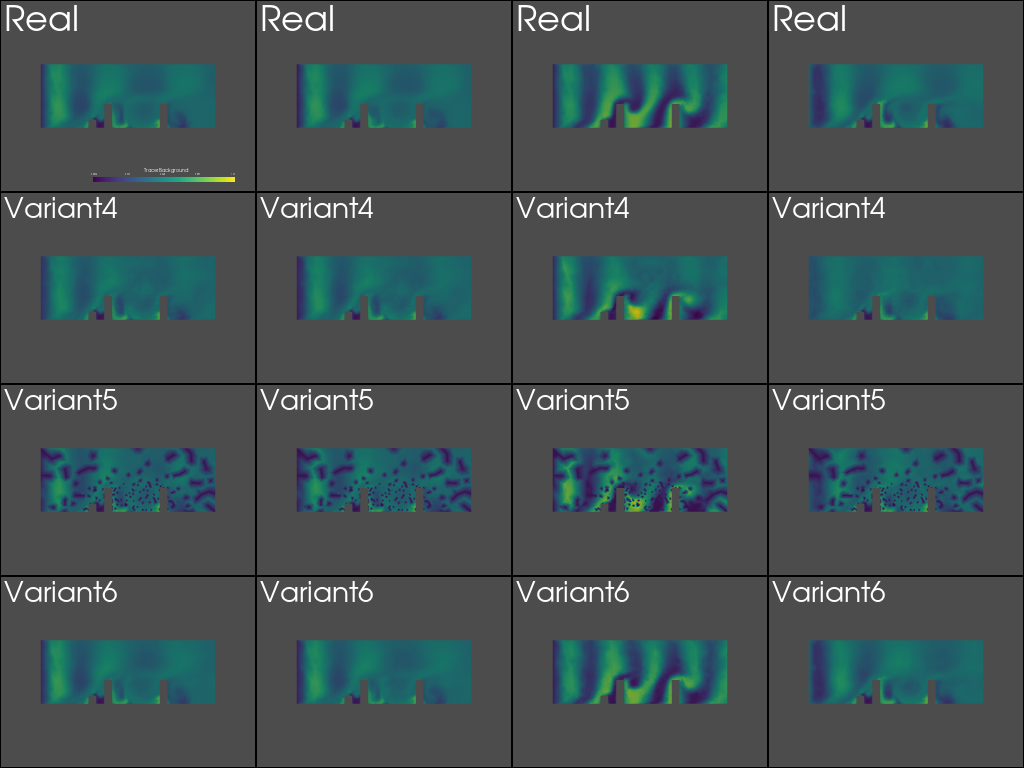

In [30]:
compare_three_plots_models_2d_vtu(variant4, variant5, variant6, 
                            graph_data_list_test, 4 , filename_to_copy_structure, 
                            random=True,
                                  set_pred_labels_as = ["Variant4", "Variant5", "Variant6"],
                                 save_fig=True, filename='air_pollution_model2_variants_4to6.eps')

The best results were obtained by variants 3 and 6; it is also possible to plot results for these models only

Indexes plotted [20 38 18]


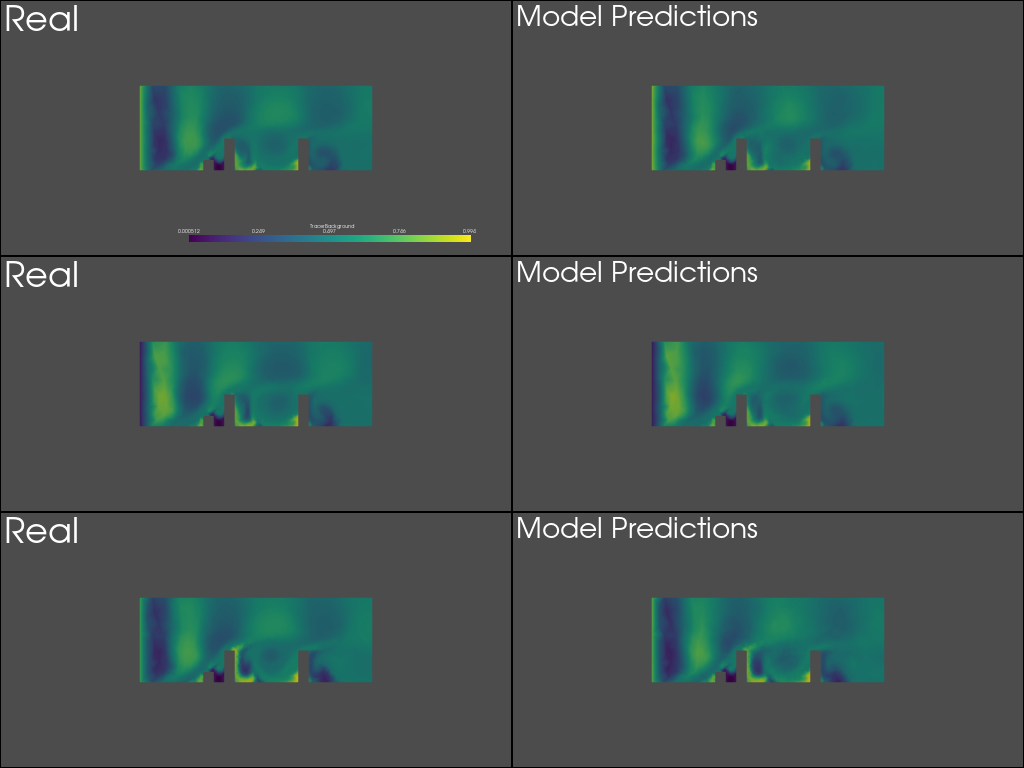

In [31]:
plot_model_2d_vtu(variant3, graph_data_list_test, 3 , filename_to_copy_structure , random=True)

Indexes plotted [1, 20, 35]


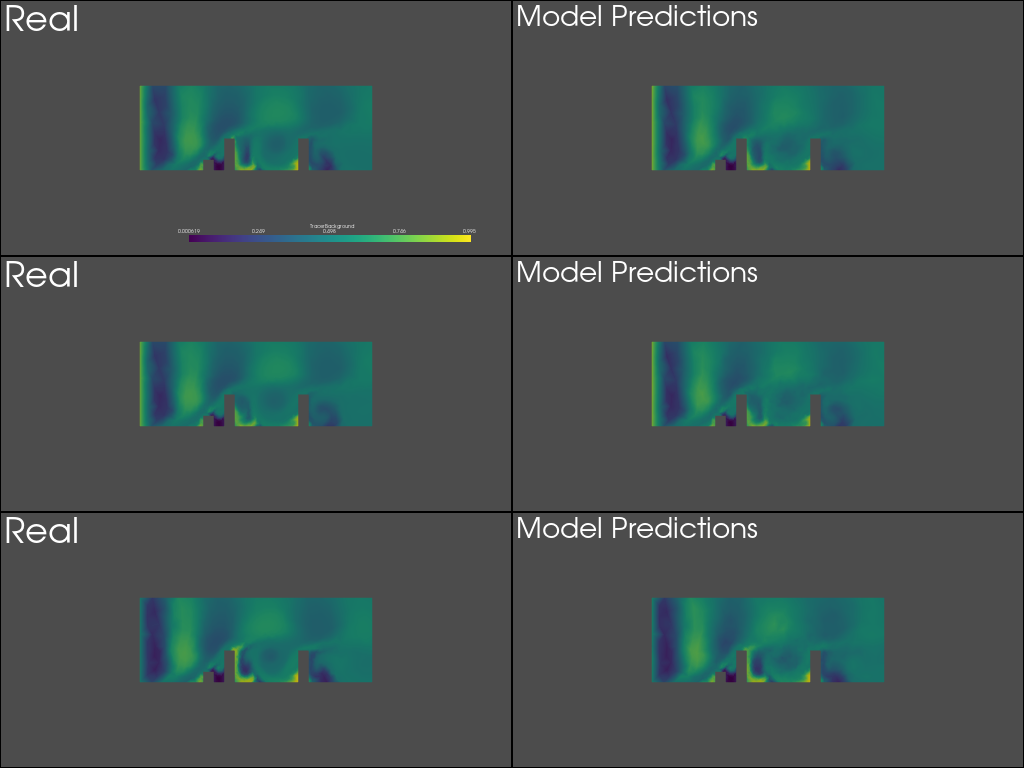

In [32]:
plot_model_2d_vtu(variant6, graph_data_list_test, 2 , filename_to_copy_structure , random=False, index_sequence=[1,20, 35] )